# Mixed IR/SE
This document attempts to describe the procedure for estimation of $T_1$-time within cerebrospinal fluid based on the interleaved inversion-recovery, spin-echo (Mixed IR/SE) MRI-data for fast $T_1$-time estimates within cerebrospinal fluid (CSF).

The steps include:
- Converting necessary volumes from enhanced DICOM to Nifti.
- Running FreeSurfer on a pre-contrast $T_1$-weighted image --- potentially supported by either FLAIR or a $T_2$-weighted image --- for the purpose of extrapolating FreeSurfer brain segmentations to the CSF-space.
- Estimating the $T_1$-time by using a lookup-table for the ratio between the inversion recovery and spin-echo signal.
- Registering the Mixed IR/SE images to the reference space of the pre-contrast $T_1$-weighted image.
- Automated masking of the CSF-space based on the (registered) pre-contrast spin-echo volume.
- Extrapolating a reduced FreeSurfer-segmentation to the CSF-space.
- Estimating contrast concentrations in the CSF-space from the $T_1$-maps.

The code relies heavily on the python package `gmri2fem`, an open-source python library designed for processing of the gMRI-data acquired in the GRIP-project. It is pip-installable, and source code is available at (https://github.com/jorgenriseth/gMRI2FEM.git).

Further dependencies include:
 - FreeSurfer
     - May optionally be replaced by FastSurfer
 - Greedy: Fast deformable image registration

## Converting enhanced DICOM-images to Nifti
We prefer to work with Nifti-images over DICOM-images due to concerns related to anonymization, storage effieciency, generalizability, and simplicity.
Note that due to differences between project structure, MRI-machine vendor etc., this procedure is specific to our project, and might not be directly applicable for a different project. We still include a description of it for transparency, and for use as a starting point for other projects.

Most DICOM-images, including the $T_1$-weighted and FLAIR images, may safely be  converted from Enhanced DICOM format to Nifti using the tool `dcm2niix` [https://github.com/rordenlab/dcm2niix].
For the Mixed IR/SE-sequence, however, it converts the data in an inconcistent way, where it ocasionally outputs all six volumes as expected, but at other times, it outputs fewer number of images where some of them might contain two volumes as one. 
We have therefore written a custom script for converting mixed-sequences from DICOM to Nifti.
The script is available on (https://github.com/jorgenriseth/gMRI2FEM/blob/f11a9961b3689250d7fd6cf41357dd7d99a53f68/src/gmri2fem/mixed_dicom.py), and may be called 
as follows.

```bash
gmri2fem dcm2nii-mixed --subvolume IR-corrected-real --subvolume SE-modulus \
    path/to/dicom/file/for/subject/session/IM_XXXX \
    mri_dataset/$subject/$session/mixed/${subject}_${session}_acq-mixed
```


## Necessary data
- `mri_dataset/$subject/ses-01/anat/${subject}_ses-01_T1w.nii.gz`
- `mri_dataset/$subject/ses-01/anat/${subject}_ses-01_FLAIR.nii.gz`
- `mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_IR-corrected-real.nii.gz`
- `mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_SE-modulus.nii.gz`

## Running FreeSurfer
```bash
recon-all -all  \
    -s $subject \
    -sd mri_processed_data/freesurfer \
    -FLAIR mri_dataset/$subject/ses-01/anat/${subject}_ses-01_FLAIR.nii.gz \
    -FLAIRpial \
    -parallel 
```
**PS**: This step may take quite a lot of time. For the purpose of extrapolating segments, you could also consider to use the much faster deep-learning-based `FastSurfer`, which is a drop-in replacement for FreeSurfer.
Any potential differences between the segmentations should have minimal impact for the analysis of the mixed-article.


## Estimating $T_1$-times.
The $T_1$-maps of the mixed sequence are estimated by comparing the voxelwise ratio of the signal intenstities to a look-up table. The command to generate the mixed T1maps is

```bash
gmri2fem mri t1map-mixed \
    --SE mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_SE-modulus.nii.gz \
    --IR mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_IR-corrected-real.nii.gz \
    --meta mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_meta.json \
    --output mri_dataset/derivatives/$subject/$ses/${subject}_${ses}_acq-mixed_T1map_raw.nii.gz
```

For details on how this is done, see (https://github.com/jorgenriseth/gMRI2FEM/blob/f11a9961b3689250d7fd6cf41357dd7d99a53f68/src/gmri2fem/mixed_t1map.py).

### Registering to common image space
For longitudinal analysis of the images taken of the same subject at different sessions, we need to register them all to a common image space.
For this purpose we use the software `greedy` which is bundled with ITK-snap, or can be downloaded separately.
We are only interested in registering images for the same subject, and therefore only consider rigid registration between the sessions.
As the reference-image we use the pre-contrast $T_1$-weighted image, which is used by FreeSurfer for the original brain segmentation.

`greedy` works in a two-step process: First the registration procedure is applied to find the best --- in this case, affine --- transformation mapping the data from a moving image (the mixed-images) to the fixed image (the $T_1$-weighted image).
The transformation is outputted as a separate text-file as a transformation matrix using homogeneneous coordinates.
This transformation may in turn be used to "reslice" the moving image (and any images aligned with it) into the image space of the target image.

For registering the Mixed IR/SE images, we use the following command to register the pre-contrast SE-modulus image to the reference image:
```bash
greedy -d 3 -a \
 -i mri_dataset/$subject/ses-01/anat/${subject}_$ses-01_T1w.nii.gz \
     mri_dataset/$subject/ses-01/mixed/${subject}_ses-01_acq-mixed_SE-modulus.nii.gz \
 -o mri_processed_data/$subject/transforms/{subject}_{session}_acq-mixed.mat \
 -ia-image-centers \
 -dof 6 \
 -m NMI
```

```bash
greedy -d
 -rf mri_dataset/$subject/ses-01/anat/${subject}_$ses-01_T1w.nii.gz \
 -ri NN \
 -rm mri_dataset/$subject/ses-01/mixed/${subject}_ses-01_acq-mixed_SE-modulus.nii.gz \
     mri_processed_data/$subject/registered/${subject}_ses-01_acq-mixed_SE-modulus_registered.nii.gz
 -r mri_processed_data/$subject/transforms/{subject}_{session}_acq-mixed.mat
```

The SE-modulus images from the remaining sessions are in turn registered to the already registered pre-contrast SE-modulus image by
```bash
greedy -d 3 -a \
 -i mri_processed_data/$subject/registered/${subject}_ses-01_acq-mixed_SE-modulus_registered.nii.gz \ 
     mri_dataset/$subject/$ses/mixed/${subject}_${ses}_acq-mixed_SE-modulus.nii.gz \
 -o mri_processed_data/$subject/transforms/{subject}_{session}_acq-mixed.mat \
 -ia-image-centers \
 -dof 6 \
 -m NCC 5x5x5
```

Finally each of the transformations are applied to the corresponding $T_1$-map:
```bash
greedy -d
 -rf mri_dataset/$subject/ses-01/anat/${subject}_$ses-01_T1w.nii.gz \
 -ri NN \
 -rm mri_dataset/derivatives/$subject/$ses/${subject}_ses-01_acq-mixed_T1map_raw.nii.gz \
     mri_processed_data/$subject/registered/${subject}_ses-01_acq-mixed_T1map_raw_registered.nii.gz
 -r mri_processed_data/$subject/transforms/{subject}_{session}_acq-mixed.mat
```

# Automated CSF-segmentation

1. Create a CSF-mask from the pre-contrast SE-modulus image as the base for the CSF-segmentation.
1. Create a reduced segmentation from `aparc+aseg.mgz`, referred to as the "pre-csf" segmentation which excludes labels that should not be exposed to the CSF-filled spaces.
1. Extrapolate the reduced segmentation to the CSF-mask.
1. Create "grouped segmentations"

The different segmenations are shown below.

In [1]:
import os

import simple_mri as sm
import numpy as np
import matplotlib.pyplot as plt

from gmri2fem import segment_tools as segtools
from gmri2fem.csf_segmentation import create_csf_seg
from gmri2fem.visualization import slice_volume
from gmri2fem.segment_tools import find_description_label, find_label_description

subject = os.environ["SUBJECT"]
aparc_mri = sm.load_mri(
    f"mri_processed_data/freesurfer/{subject}/mri/aparc+aseg.mgz",
    dtype=np.int16,
)

mask_base_mri = sm.load_mri(
    f"mri_processed_data/{subject}/registered/{subject}_ses-01_acq-mixed_SE-modulus_registered.nii.gz",
    dtype=np.single
)
csf_seg_mri = create_csf_seg(aparc_mri, mask_base_mri)

## Create grouped segmentations

In [2]:
def to_cortex_labels(description_list):
    """Map a cortical region-description to it's corresponding FreeSurfer name
    for both left and right hemisphere."""
    return (
        [f'ctx-lh-{d.lower().replace(" ", "")}' for d in description_list]
        + [f'ctx-rh-{d.lower().replace(" ", "")}' for d in description_list]
    )


ventricles = [
    "3rd-Ventricle",
    "4th-Ventricle",
    "Left-Lateral-Ventricle",
    "Right-Lateral-Ventricle",
    "Left-Inf-Lat-Vent",
    "Right-Inf-Lat-Vent",
]

infratentorial = [
    "Brain-Stem",
    "Left-Cerebellum-Cortex",
    "Right-Cerebellum-Cortex",
]

basal = [
    *to_cortex_labels([
        "medial orbitofrontal",
        "fusiform",
        "frontal pole",
    ]),
    "Optic-Chiasm",
    "Left-VentralDC",
    "Right-VentralDC",
    "Left-Hippocampus",
    "Right-Hippocampus"
]

medial = to_cortex_labels([
    "Posterior cingulate",
    "Rostral anterior cingulate",
    "Caudal anterior cingulate",
    "Superiorfrontal",
    "Precuneus",
    "Isthmus cingulate",
    "Paracentral",
    "Cuneus",
    "Lingual",
    "Pericalcarine",
    "Entorhinal",
    "Parahippocampal"
])

insula = to_cortex_labels([
    "Insula",
])

In [3]:
groups = {
    "ventricles": ventricles,
    "infratentorial": infratentorial,
    "basal": basal,
    "medial": medial,
    "insula": insula,
}

lut_table = segtools.read_lut(f"{os.environ['FREESURFER_HOME']}/FreeSurferColorLUT.txt")
labels = np.unique(csf_seg_mri.data[csf_seg_mri.data > 0])
grouped_descriptions = sum(groups.values(), start=[])
grouped_labels = [find_description_label(x, lut_table) for x in grouped_descriptions]
groups["lateral"] = [find_label_description(x, lut_table) for x in labels[~np.isin(labels, grouped_labels)] ]
relabeling = {
    group: [segtools.find_description_label(x, lut_table) for x in group_descriptions]
    for group, group_descriptions in groups.items()
}


grouped_seg = segtools.collapse(csf_seg_mri.data, relabeling)
grouped_seg_mri = sm.SimpleMRI(grouped_seg, csf_seg_mri.affine)
sm.save_mri(
    grouped_seg_mri,
    f"mri_processed_data/{subject}/segmentations/{subject}_seg-csf_grouped.nii.gz",
    np.int16
)

# Also create a lookup-table for identifying regions
grouped_lut = segtools.canonical_lut(relabeling, "jet", permute_colors=None)
grouped_cmap = segtools.listed_colormap(grouped_lut)
segtools.write_lut(
    f"mri_processed_data/{subject}/segmentations/{subject}_seg-csf_grouped_LUT.txt",
    grouped_lut
)

### Cerebellum-Ventricle-SAS segmentation

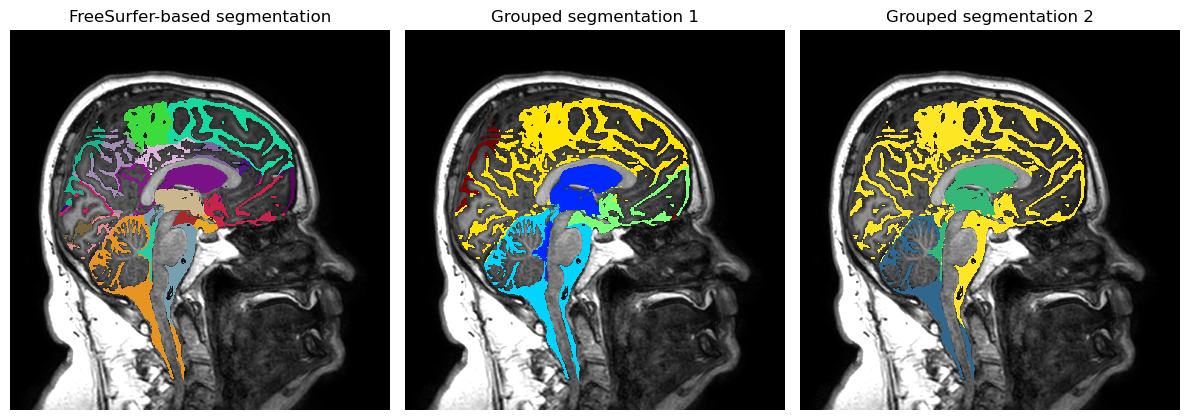

In [4]:
cerebellum = [
    "Left-Cerebellum-Cortex",
    "Right-Cerebellum-Cortex",
]
labels = np.unique(csf_seg_mri.data[csf_seg_mri.data > 0])
relabeling = {
    "cerebellum": [find_description_label(x, lut_table) for x in cerebellum],
    "ventricles": [find_description_label(x, lut_table) for x in ventricles]
}
relabeling["SAS"]= list(labels[~np.isin(labels, relabeling["cerebellum"] + relabeling["ventricles"])])

groups = {
    desc: [find_label_description(x, lut_table) for x in group_labels]
    for desc, group_labels in relabeling.items()
}

newlut = segtools.canonical_lut(relabeling, "viridis", permute_colors=None)
newseg_cmap = segtools.listed_colormap(newlut)
newseg = segtools.collapse(csf_seg_mri.data, relabeling)
newseg_mri = sm.SimpleMRI(newseg, csf_seg_mri.affine)
sm.save_mri(
    newseg_mri,
    f"mri_processed_data/{subject}/segmentations/{subject}_seg-csf_sas-ventricle-cerebellum.nii.gz",
    np.int16
)
segtools.write_lut(
    f"mri_processed_data/{subject}/segmentations/{subject}_seg-csf_sas-ventricle-cerebellum-LUT.txt",
    newlut
)

lut_table = segtools.read_lut(f"{os.environ['FREESURFER_HOME']}/FreeSurferColorLUT.txt")
fs_cmap = segtools.listed_colormap(lut_table)

slice_ = ("sagittal", 184)


t1w_mri = sm.load_mri(
    f"mri_processed_data/{subject}/registered/{subject}_ses-01_T1w_registered.nii.gz",
    dtype=np.single
)
t1w = t1w_mri.data
im_ref = slice_volume(t1w, *slice_)
im_segmentations = [slice_volume(mri.data, *slice_) for mri in [csf_seg_mri, grouped_seg_mri, newseg_mri]]


fig, axes = plt.subplots(1, 3, figsize=(12, 6))
for ax in axes:
    ax.imshow(im_ref, cmap="gray", vmin=0, vmax=np.quantile(t1w[t1w > 0], 0.95))
    ax.axis("off")
    
for ax, seg, cmap in zip(axes, im_segmentations, [fs_cmap, grouped_cmap, newseg_cmap]):
    ax.imshow(np.where(seg > 0, seg, np.nan), **cmap, interpolation="nearest")
    
axes[0].set_title("FreeSurfer-based segmentation")
axes[1].set_title("Grouped segmentation 1")
axes[2].set_title("Grouped segmentation 2")

plt.tight_layout()
plt.show()